In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import squarify

In [2]:
columns = ['Order_date', 'Order_ID', 'Purchased_product_ID', 'Quantity_of_SKU_in_the_order', 'Category_ID', 'Category_alias', 'Brand_ID', 'Price', 'User_ID', 'Product_gender', 'Colour', 'Metal', 'Gem']

In [3]:
df = pd.read_csv('C:/Users/vikam/Desktop/Analytics/jewelry.csv', names=columns)

In [4]:
df.head(4)

,Order_date,Order_ID,Purchased_product_ID,Quantity_of_SKU_in_the_order,Category_ID,Category_alias,Brand_ID,Price,User_ID,Product_gender,Colour,Metal,Gem
0,2018-12-01 11:40:29 UTC,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond


In [5]:
df.dtypes

Order_date                       object
Order_ID                          int64
Purchased_product_ID              int64
Quantity_of_SKU_in_the_order      int64
Category_ID                     float64
Category_alias                   object
Brand_ID                        float64
Price                           float64
User_ID                         float64
Product_gender                   object
Colour                           object
Metal                            object
Gem                              object
dtype: object

In [6]:
df['Order_date'] = df['Order_date'].apply(lambda x: x.replace(' UTC', ''))

In [7]:
df['Order_date'] = df['Order_date'].apply(pd.to_datetime)

In [8]:
df['Month_of_order'] = df['Order_date'].map(lambda x: x.strftime('%Y-%m'))

In [9]:
df['Order_date'].min()

Timestamp('2018-12-01 11:40:29')

In [10]:
df['Order_date'].max()

Timestamp('2021-12-01 09:59:07')

→ Данные за декабрь 2021 неполные, уберем этот месяц из датафрейма

In [11]:
df = df.loc[df['Month_of_order'] != '2021-12']

In [12]:
orders = df.groupby(['User_ID', 'Month_of_order']).agg({'Order_ID':'count', 'Price':'sum'}) \
.rename(columns={'Order_ID':'Orders', 'Price':'Revenue'})

 ### Сколько и на какую сумму каждый месяц делают заказов?

In [13]:
orders_by_month = orders.groupby('Month_of_order').agg({'Orders':'sum', 'Revenue':'sum'}).reset_index()

In [14]:
orders_by_month.head()

,Month_of_order,Orders,Revenue
0,2018-12,122,33935.77
1,2019-01,566,191471.91
2,2019-02,779,240286.89
3,2019-03,636,216889.54
4,2019-04,673,229081.68


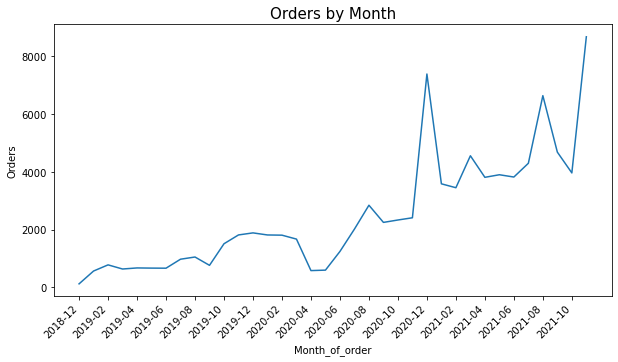

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Orders')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Orders by Month", fontsize = 15);

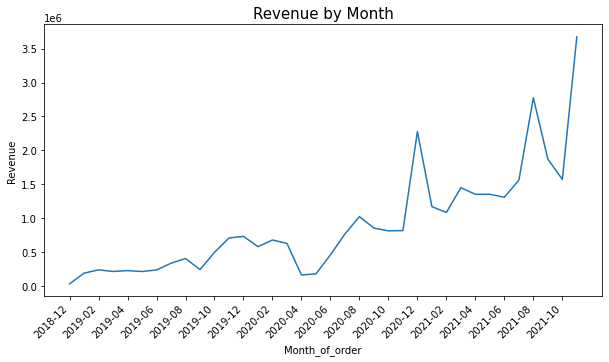

In [16]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Revenue')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Revenue by Month", fontsize = 15);

In [17]:
diff_between_first_and_last_months = orders_by_month.query("Month_of_order in ['2018-12', '2021-11']")[['Orders', 'Revenue']].pct_change()
diff_between_first_and_last_months

,Orders,Revenue
0,NaN,NaN
35,70.090164,107.281834


→ Несмотря на периодические спады в продажах, обусловленные сезонными колебаниями, количество заказов и доходы от них непрерывно росли на протяжении всех трех лет. По сравнению с декабрем 2018 года продажи выросли на 70%, а доходы - на 107%.

### AOV по годам

In [18]:
AOV = df.groupby([df['Order_date'].dt.year, 'Order_ID']).agg({'Price':'mean'}).reset_index()
AOV = AOV.groupby('Order_date').agg({'Price':'mean'}).rename(columns={'Price':'AOV'}).reset_index()
AOV

,Order_date,AOV
0,2018,295.810553
1,2019,354.772958
2,2020,338.844893
3,2021,371.962621


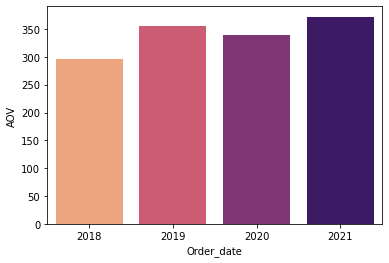

In [19]:
sns.barplot(data=AOV, x='Order_date', y='AOV', palette='magma_r');

### APC по годам

In [20]:
APC = df.groupby(df['Order_date'].dt.year).agg({'User_ID':'nunique', 'Order_ID':'count'}).reset_index()
APC['APC'] = APC['Order_ID'] / APC['User_ID']
APC = APC[['Order_date', 'APC']]
APC

,Order_date,APC
0,2018,1.848485
1,2019,4.458732
2,2020,3.025973
3,2021,2.558324


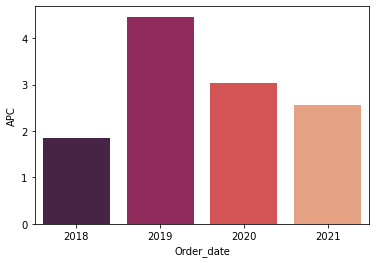

In [21]:
sns.barplot(data=APC, x='Order_date', y='APC', palette='rocket');

### ARPU по годам

In [22]:
ARPU = df.groupby(df['Order_date'].dt.year).agg({'User_ID':'nunique', 'Price':'sum'}).reset_index()
ARPU['ARPU'] = ARPU['Price'] / ARPU['User_ID']
ARPU = ARPU[['Order_date', 'ARPU']]
ARPU

,Order_date,ARPU
0,2018,514.178333
1,2019,1571.363445
2,2020,1032.469323
3,2021,870.589879


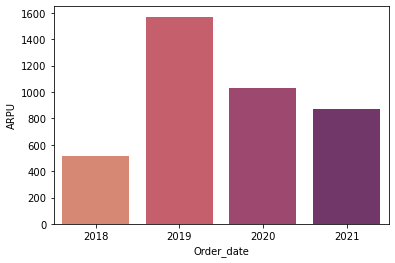

In [23]:
sns.barplot(data=ARPU, x='Order_date', y='ARPU', palette='flare');

→ Несмотря на то, что средний чек вырос по сравнению с предыдущими годами, количество заказов на человека и доход с одного пользователя после 2019 г. ежегодно снижался (мы не берем в расчет 2018 г., поскольку у нас нет полных данных за этот год).

### Repeat Purchase Rate

Частота повторных покупок по когортам

In [73]:
first_order = df.groupby('User_ID', as_index=False).agg({'Order_date':'min'}).rename(columns={'Order_date':'First_order'})

In [74]:
df = df.merge(first_order, on='User_ID')

In [75]:
df['Date_diff'] = (df['Order_date'] - df['First_order']).dt.days

In [76]:
df['Cohort_period'] = pd.cut(df['Date_diff'], [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365, 100000], 
                             labels=['0 day', '30 d', '60 d', '90 d', '120 d', '150 d', '180 d', '210 d', '240 d', '270 d', '300 d', '330 d', '365 d', '>365 d'])

In [93]:
cohort_size = df.groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'}) \
.rename(columns={'User_ID':'Cohort_size'}).reset_index()

In [89]:
repeat_purchase = df.loc[df['Date_diff'] > 0].groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'}) \
.rename(columns={'User_ID':'Repeat_customers'}).reset_index()

In [90]:
repeat_purchase_rate = cohort_size.merge(repeat_purchase, on='First_order')

In [91]:
repeat_purchase_rate['Repeat_purchase_rate'] = repeat_purchase_rate['Repeat_customers'] / repeat_purchase_rate['Cohort_size']

In [95]:
repeat_purchase_rate.tail()

,First_order,Cohort_size,Repeat_customers,Repeat_purchase_rate
31,2021-07,1618,209,0.129172
32,2021-08,2214,298,0.134598
33,2021-09,1564,145,0.092711
34,2021-10,1490,156,0.104698
35,2021-11,3737,290,0.077602


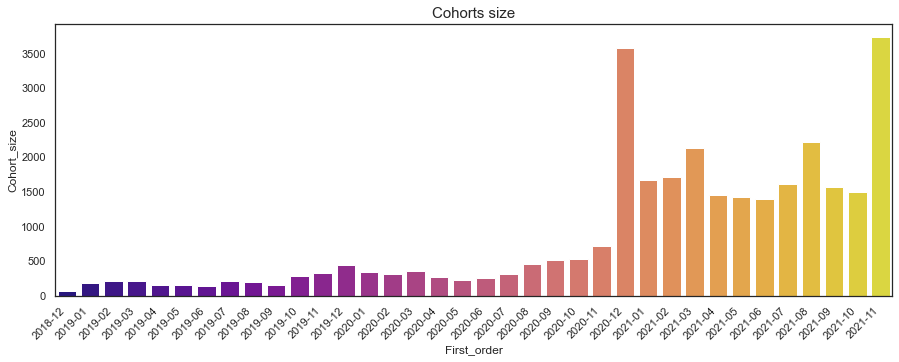

In [94]:
plt.figure(figsize=(15, 5))
sns.barplot(data=cohort_size, x='First_order', y='Cohort_size', palette='plasma')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Cohorts size", fontsize = 15);

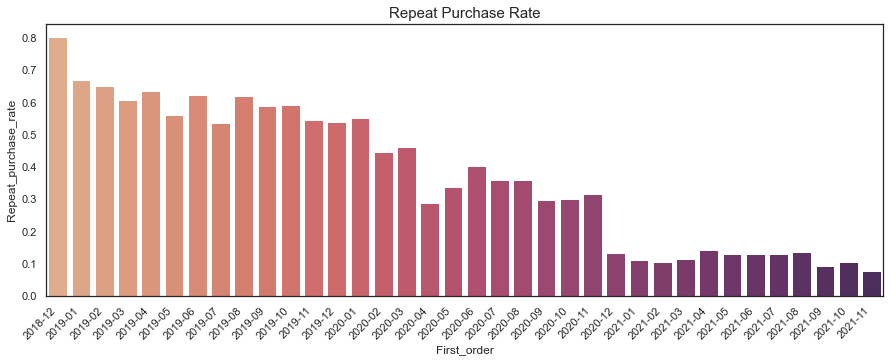

In [86]:
plt.figure(figsize=(15, 5))
sns.barplot(data=repeat_purchase_rate, x='First_order',y='Repeat_purchase_rate', palette='flare')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Repeat Purchase Rate", fontsize = 15);

→ Изначально магазин имел хорошие показатели возврата посетителей: до начала 2020 г. коэффицент повторных покупок не падал ниже 0.5, а, значит, >50% пользователей, сделавших заказ в магазине, возвращались в него снова. Однако после того, как количество покупателей у магазина стало стремительно расти, коэффицент повторных покупок стал падать, и к декабрю 2021 г. упал ниже 0.1.

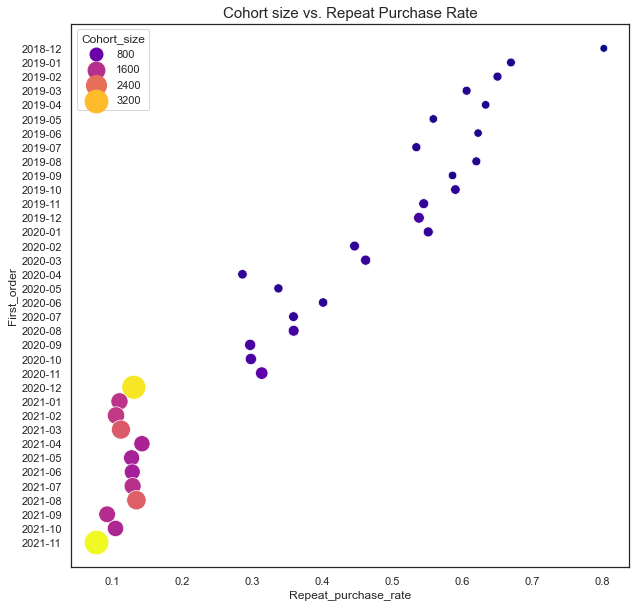

In [107]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=repeat_purchase_rate, x='Repeat_purchase_rate', y=repeat_purchase_rate.First_order.astype(str), hue='Cohort_size',
                size='Cohort_size', sizes=(60,600), legend='brief', palette='plasma');
plt.title('Cohort size vs. Repeat Purchase Rate', fontsize = 15);

→ Из графика видно, что чем больше размер когорты, тем меньше частота повторных покупок.

### Retention Rate

Посмотрим подробнее на удержание клиентов в первый год после совершения целевого действия

In [96]:
cohort_0 = df.query("Cohort_period=='0 day'").groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'})['User_ID']

In [97]:
cohorts = df.groupby([df['First_order'].dt.to_period('M'), 'Cohort_period']).agg({'User_ID':'nunique'}).reset_index()

In [98]:
cohorts = cohorts.loc[cohorts['Cohort_period'] != '>365 d']

In [99]:
cohorts = cohorts.pivot(index=['First_order'], columns=['Cohort_period'], values=['User_ID'])

In [100]:
cohorts = cohorts.divide(cohort_0, axis=0)

In [101]:
cohorts.columns = cohorts.columns.droplevel(0)

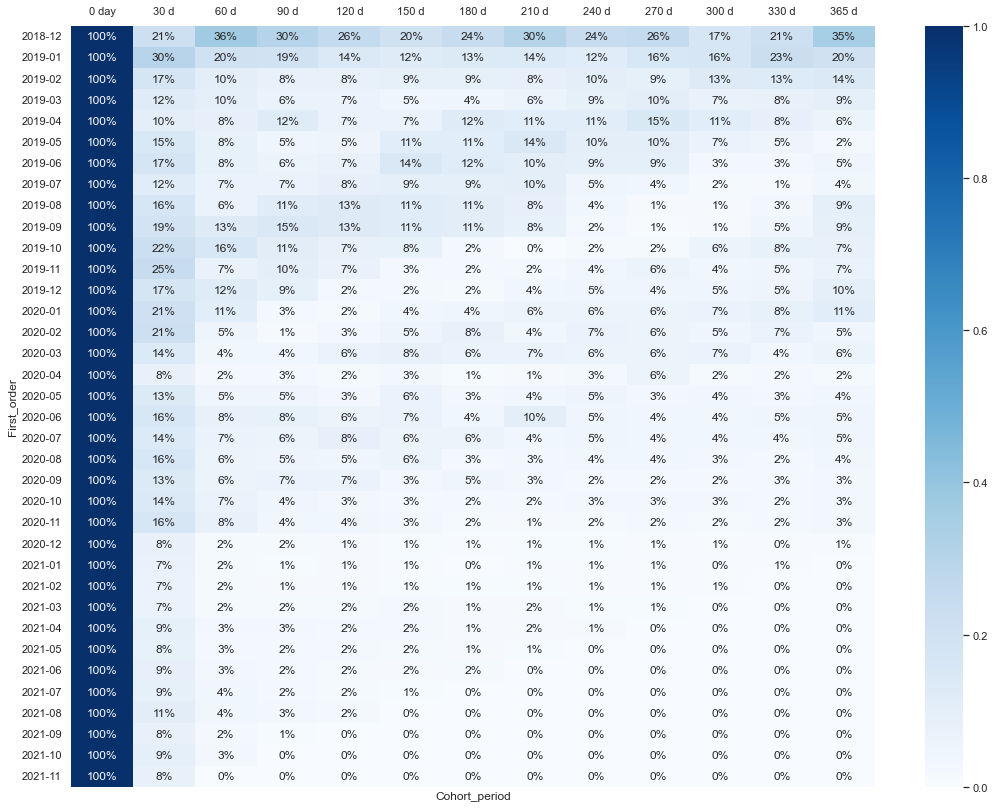

In [102]:
sns.set(style='white')
plt.figure(figsize=(18, 14))
sns.heatmap(cohorts, annot=True, fmt='.0%', cmap="Blues").tick_params(labelbottom=False,labeltop=True)

→ Из таблицы видно, что коэффицент удержания почти непрерывно падал. Если для когорты 2018-12 доля пользователей, вернувшихся в первые 30 дней, составляла 21%, то для когорты 2021-11 - только 8%. Вероятнее всего, бизнес был ориентирован на привлечение новых пользователей, отсюда такое резкое увеличение числа заказов, но не занимался их удержанием.

### RFM анализ
R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [179]:
last_date = df['Order_date'].max()

In [153]:
df['Days_since_order'] = (last_date - df['Order_date']).dt.days

In [157]:
rfm_df = df.groupby('User_ID', as_index=False).agg({
                                     'Order_date': lambda x: (last_date - x.max()).days,
                                     'Order_ID': lambda x: len(x),
                                     'Price': lambda x: x.sum()})

In [158]:
rfm_df.rename(columns={'Order_date':'Recency', 'Order_ID':'Frequency', 'Price':'Monetary'}, inplace=True)

In [159]:
rfm_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,31011.000000,31011.000000,31011.000000
mean,247.510786,2.915546,1055.810347
std,204.244690,14.524620,6461.606760
min,0.000000,1.000000,1.030000
25%,90.000000,1.000000,165.620000
50%,227.000000,1.000000,335.480000
75%,340.000000,2.000000,698.360000
max,1093.000000,1068.000000,458708.740000


In [167]:
rfm_df['R'] = pd.cut(rfm_df['Recency'], bins=[0, 30, 200, 360, 10000], labels=[1, 2, 3, 4])
rfm_df['R_description'] = pd.cut(rfm_df['Recency'], bins=[0, 30, 200, 360, 10000], labels=['Недавние', 'Спящие', 'Давние', 'Ушедшие'])

In [168]:
rfm_df['F'] = pd.cut(rfm_df['Frequency'], bins=[0, 1, 5, 15, 10000], labels=[1, 2, 3, 4])
rfm_df['F_description'] = pd.cut(rfm_df['Frequency'], bins=[0, 1, 5, 15, 10000], labels=['Разовые', 'Редкие', 'Частые', 'Постоянные'])

In [169]:
rfm_df['M'] = pd.cut(rfm_df['Monetary'], bins=[0, 300, 1000, 5000, 1000000], labels=[1, 2, 3, 4])
rfm_df['M_description'] = pd.cut(rfm_df['Monetary'], bins=[0, 300, 1000, 5000, 1000000], labels=['С низким чеком', 'Со средним чеком', 'С высоким чеком', 'С очень высоким чеком'])

In [170]:
rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

In [171]:
rfm_df.head()

,User_ID,Recency,Frequency,Monetary,R,R_description,F,F_description,M,M_description,RFM
0,1.313554e+18,521,1,272.47,4,Ушедшие,1,Разовые,1,С низким чеком,411
1,1.313556e+18,56,6,3818.79,2,Спящие,3,Частые,3,С высоким чеком,233
2,1.313566e+18,103,5,2814.39,2,Спящие,2,Редкие,3,С высоким чеком,223
3,1.313582e+18,134,1,130.00,2,Спящие,1,Разовые,1,С низким чеком,211
4,1.313591e+18,435,8,2067.09,4,Ушедшие,3,Частые,3,С высоким чеком,433


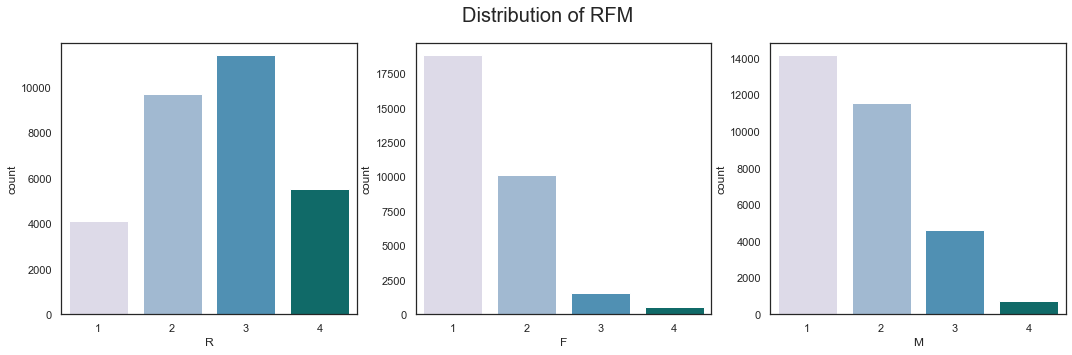

In [175]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
sns.countplot(data=rfm_df, x='R', palette='PuBuGn', ax = axes[0]);
sns.countplot(data=rfm_df, x='F', palette='PuBuGn', ax = axes[1]);
sns.countplot(data=rfm_df, x='M', palette='PuBuGn', ax = axes[2]);
plt.suptitle("Distribution of RFM", fontsize = 20);

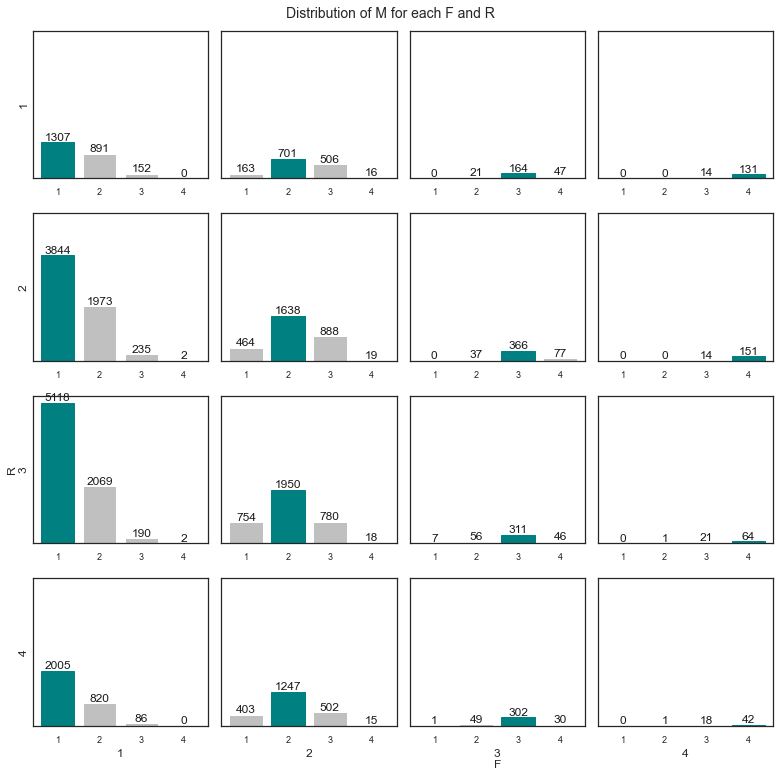

In [177]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(11, 11))
r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm_df[(rfm_df['R'] == r) & (rfm_df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 4:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=9)
        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('teal')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

→ БОльшая часть покупок приходится на клиентов, которые делают заказы либо редко, либо вообще единоразово. При этом на клиентов, которые сделали только один заказ (F=1), приходится самый низкий чек, а на постоянных клиентов (F=4) - самый высокий. <br />
Что касается показателя Recency, то бОльшая часть покупок приходится на период около полугода-года назад (R=3), когда большое количество пользователей сделало единоразовые заказы (F=1) на маленькие суммы (M=1). Возможно, речь идет о декабре 2020 г., когда наблюдался резкий всплеск заказов, приуроченный к новогодним праздникам. <br />
Также из графиков видно, что поведение клиентов практически никак не менялось во времени, и для каждого из показателей Recency показатели Frequency и Monetary распределялись примерное одинаково, что также говорит о том, что компания работала только на привлечение новых клиентов, но не стимулировала покупателей к повторным покупкам или трате больше денег.

Выводы: при сохранении текущего маркетингового плана, обеспечивающего магазину приток новых покупателей, компании следует заняться повышением ценности своего продукта для потребителя, чтобы вернуться к показателям 2019 г. по среднему числу покупок, доходу на одного пользователя и коэффиценту возвращаемости, а впоследствии и перегнать их.